Загрузим необходимые библиотеки

In [2]:
!pip install beautifulsoup4
# !pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем необходимые библиотеки.

In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as BS
import re
import matplotlib.pyplot as plt
import seaborn as sns
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from xgboost import XGBClassifier
# from sklearn.decomposition import PCA

Создадим функцию для парсинга статистики игрока, которая на вход принимает url откуда парсить статистику

In [4]:
def pars_stat(url):
  response = requests.get(url)
  html = BS(response.content, 'html.parser')
  data = html.find_all('tbody')
  test = data[0].text.replace('\n\n\xa0\n2-очковые\n3-очковые\nШтрафные\nПодборы\n\xa0\n\n\nДата\nТурнир\nКоманды\nСчет\nО\nЗ\nВ\n%\nЗ\nВ\n%\nЗ\nВ\n%\nПН\nПЗ\nПВ\nАП\nФ\nПХ\nП\nБШ\nМин\n\n\n\n\n', '')
  test = re.sub('\\n–\\n ', '-', test)
  test = re.sub('(\\n)+', '\\n', test)
  test = re.split('\\n', test)
  test = test[:-1]
  return test

Создадим функцию для заполнения датафрейма, которая на вход принимает список статистики, имя игрока и команду, в которой он играет, а возвращает датафрейм данных

In [5]:
def dataframe_fill(stat, name, team):
  ans = {'Дата' : [],
       'Лига': [],
       'Команды': [],
       'Счёт':[],
       'Очки':[],
       'Забитые 2-очковые':[],
       'Попытки 2-очковые':[],
       '% 2-очковых':[],
       'Забитые 3-очковые':[],
       'Попытки 3-очковые':[],
       '% 3-очковых':[],
       'Забитые штрафные':[],
       'Попытки штрафные':[],
       '% штрафных':[],
       'Подборы в нападении':[],
       'Подборы в защите':[],
       'Всего подборов':[],
       'Ассисты':[],
       'Фолы':[],
       'Перехваты':[],
       'Потери':[],
       'Блокшоты':[],
       'Минуты':[]
       }
  keys = list(ans.keys())
  j = 0
  while j < len(stat):
    i = 0
    while i < len(keys):
      if stat[j] == 'Неиспользованная замена':
        while i < len(keys):
          ans[keys[i]].append(None)
          i += 1
      else:   
        ans[keys[i]].append(stat[j])
      i += 1
      j += 1
  ans['Имя'] = name
  ans['Команда'] = team
  return pd.DataFrame(ans)

Парсим таблицы ТОП-10 игроков по очкам, передачам, подборам, блокшотам и перехаватам

In [6]:
url = 'https://www.sports.ru/nba/stat/'

response = requests.get(url)
lxml_r = BS(response.text, 'lxml')
tables = lxml_r.find_all('table', class_='stat-table')

Выделим из таблиц имена и команды ТОП-10 игроков по очкам за игру

In [7]:
players = []
names = []

# Только игроки с наибольшим количеством очков
for player in tables[0].select('tr')[1:]:
    url= player.select_one('a').get('href')
    player_row = player.find_all('td')
    name = player_row[1].text.replace('\n', '').lstrip()
    team = player_row[2].text.replace('\n', '').lstrip()
    if name not in names:
      players.append([url, name, team])  
    names.append(name)

# Все таблицы и выделение уникальных имен
# for table in tables:
#   for player in table.select('tr')[1:]:
#     url= player.select_one('a').get('href')
#     player_row = player.find_all('td')
#     name = player_row[1].text.replace('\n', '').lstrip()
#     team = player_row[2].text.replace('\n', '').lstrip()
#     if name not in names:
#       players.append([url, name, team])  
#     names.append(name)

Соберем статистику за все матчи, сыгранные игроками

In [8]:
statistic = pd.DataFrame({'Дата' : [],
       'Лига': [],
       'Команды': [],
       'Счёт':[],
       'Очки':[],
       'Забитые 2-очковые':[],
       'Попытки 2-очковые':[],
       '% 2-очковых':[],
       'Забитые 3-очковые':[],
       'Попытки 3-очковые':[],
       '% 3-очковых':[],
       'Забитые штрафные':[],
       'Попытки штрафные':[],
       '% штрафных':[],
       'Подборы в нападении':[],
       'Подборы в защите':[],
       'Всего подборов':[],
       'Ассисты':[],
       'Фолы':[],
       'Перехваты':[],
       'Потери':[],
       'Блокшоты':[],
       'Минуты':[],
       'Имя': []
       })

for player in players:
  stat = pars_stat(player[0] + 'stat/?s=8776&t=150')
  dataframe_stat = dataframe_fill(stat, player[1], player[2])
  statistic = pd.concat([statistic, dataframe_stat])
keys = list(statistic.columns)
columns = list(keys[-2:]) + keys[:-2] 
statistic = statistic[columns]
statistic

,Имя,Команда,Дата,Лига,Команды,Счёт,Очки,Забитые 2-очковые,Попытки 2-очковые,% 2-очковых,...,% штрафных,Подборы в нападении,Подборы в защите,Всего подборов,Ассисты,Фолы,Перехваты,Потери,Блокшоты,Минуты
0,Джоэл Эмбиид,Филадельфия,21.10.2021,НБА,Новый Орлеан-Филадельфия,97 : 117,22,6,14,43,...,67,1,5,6,5,3,1,1,1,25:42
1,Джоэл Эмбиид,Филадельфия,23.10.2021,НБА,Филадельфия-Бруклин,109 : 114,19,4,10,40,...,83,2,6,8,4,4,2,3,4,29:43
2,Джоэл Эмбиид,Филадельфия,25.10.2021,НБА,Оклахома-Сити-Филадельфия,103 : 115,22,6,10,60,...,67,1,8,9,6,2,1,0,3,33:17
3,Джоэл Эмбиид,Филадельфия,27.10.2021,НБА,Нью-Йорк-Филадельфия,112 : 99,14,2,5,40,...,91,1,5,6,3,1,1,5,1,30:25
4,Джоэл Эмбиид,Филадельфия,29.10.2021,НБА,Филадельфия-Детройт,110 : 102,30,7,15,47,...,87,5,13,18,3,2,1,4,0,30:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Никола Йокич,Денвер,31.03.2022,НБА,Индиана-Денвер,118 : 125,37,15,19,79,...,88,3,10,13,9,3,2,7,1,35:39
71,Никола Йокич,Денвер,02.04.2022,НБА,Денвер-Миннесота,130 : 136,38,14,19,74,...,83,5,14,19,8,2,1,4,0,43:23
72,Никола Йокич,Денвер,03.04.2022,НБА,Лейкерс-Денвер,118 : 129,38,15,19,79,...,73,1,17,18,6,3,3,7,2,32:59
73,Никола Йокич,Денвер,06.04.2022,НБА,Денвер-Сан-Антонио,97 : 116,41,17,30,57,...,67,2,15,17,4,3,2,2,0,40:23


Добавим к ДатаФрейму результат матча, разность очков команды, очки команды, очки оппонента, название команды оппонента и удалим счет, дата, лигу и команды из полученного ДатаФрейма

In [9]:
matchs_results = []
for i in range(len(statistic)):
  if statistic.iloc[i]['Команда'] + '-' in statistic.iloc[i]['Команды']:
    if int(statistic.iloc[i]['Счёт'].split(' : ')[0])  < int(statistic.iloc[i]['Счёт'].split(' : ')[1]):
      matchs_results.append(0)
    else:
      matchs_results.append(1)
  else:
    if int(statistic.iloc[i]['Счёт'].split(' : ')[0])  < int(statistic.iloc[i]['Счёт'].split(' : ')[1]):
      matchs_results.append(1)
    else:
      matchs_results.append(0)
statistic['Результат'] = matchs_results

In [10]:
matchs_delta = []
for i in range(len(statistic)):
  if statistic.iloc[i]['Команда'] + '-' in statistic.iloc[i]['Команды']:
    matchs_delta.append(int(statistic.iloc[i]['Счёт'].split(' : ')[0]) - int(statistic.iloc[i]['Счёт'].split(' : ')[1]))
  else:
    matchs_delta.append(-(int(statistic.iloc[i]['Счёт'].split(' : ')[0]) - int(statistic.iloc[i]['Счёт'].split(' : ')[1])))

statistic['Разница'] = matchs_delta

In [11]:
scores = []
for i in range(len(statistic)):
  if statistic.iloc[i]['Команда'] + '-' in statistic.iloc[i]['Команды']:
    scores.append(int(statistic.iloc[i]['Счёт'].split(' : ')[0]) )
  else:
    scores.append(int(statistic.iloc[i]['Счёт'].split(' : ')[1]))

statistic['Командные очки'] = scores

In [12]:
scores = []
for i in range(len(statistic)):
  if statistic.iloc[i]['Команда'] + '-' in statistic.iloc[i]['Команды']:
    scores.append(int(statistic.iloc[i]['Счёт'].split(' : ')[1]) )
  else:
    scores.append(int(statistic.iloc[i]['Счёт'].split(' : ')[0]))

statistic['Очки оппонента'] = scores

In [13]:
opponents = []
for i in range(len(statistic)):
  if statistic.iloc[i]['Команда'] + '-' in statistic.iloc[i]['Команды']:
    opponents.append(statistic.iloc[i]['Команды'].replace((statistic.iloc[i]['Команда']+'-'), '').lstrip())
  else:
    opponents.append(statistic.iloc[i]['Команды'].replace(('-' + statistic.iloc[i]['Команда']), '').lstrip())

statistic['Оппонент'] = opponents
statistic = statistic.drop(['Дата', 'Лига','Счёт', 'Команды'], axis = 1)

Заполним пропуски в колонке минуты на 00:00 и переведём минуты в секунды

In [14]:

statistic_fill_na = statistic.fillna('00:00')

time_playing = []
for i in range(len(statistic)):
  minutes = int(statistic_fill_na.iloc[i]['Минуты'].split(':')[0])
  seconds = int(statistic_fill_na.iloc[i]['Минуты'].split(':')[1])
  times = minutes*60+seconds
  time_playing.append(times)
statistic['Минуты'] = time_playing


Построим гистограмму по оси x отложим количество очков, а по y количество матчей с данными очками

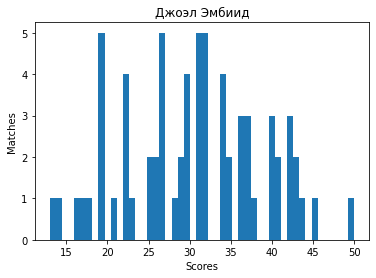

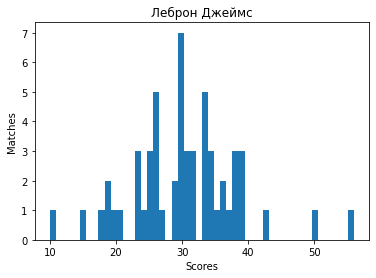

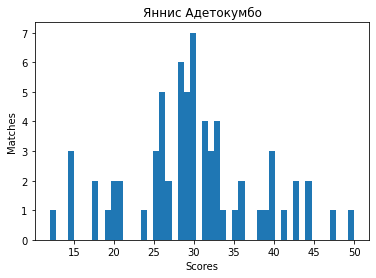

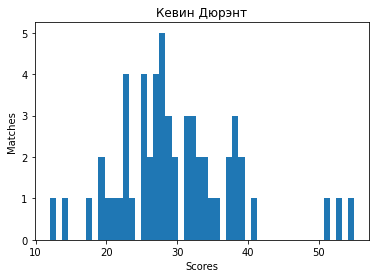

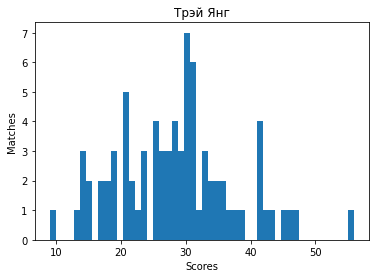

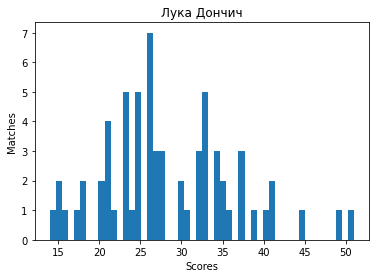

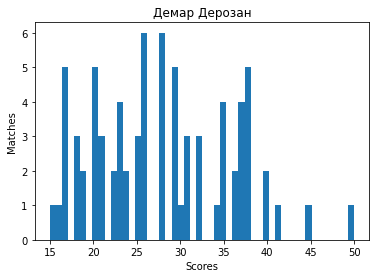

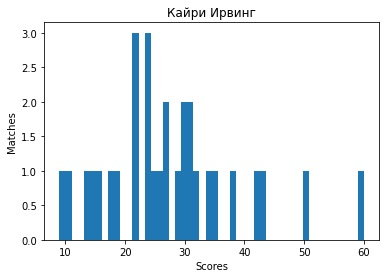

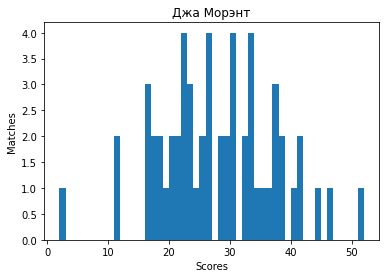

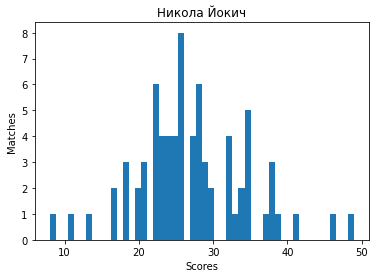

In [15]:
for name in statistic['Имя'].unique():
  plt.hist(statistic[statistic['Имя'] == name]['Очки'].dropna().astype(int), bins = 50)

  plt.xlabel('Scores')
  plt.ylabel('Matches')
  plt.title(name)
  plt.show()

Удалим все строки, где была использована замена и игрок не учавствовал в матче.

In [16]:
stat_drop = statistic.dropna()

statistic =  pd.concat([stat_drop[stat_drop.columns[:2]], \
                          stat_drop[stat_drop.columns[2:-1]].astype(int), \
                          stat_drop[stat_drop.columns[-1]]], axis = 1)

Построим корреляционную диаграмму для датафрейма атакующих данных

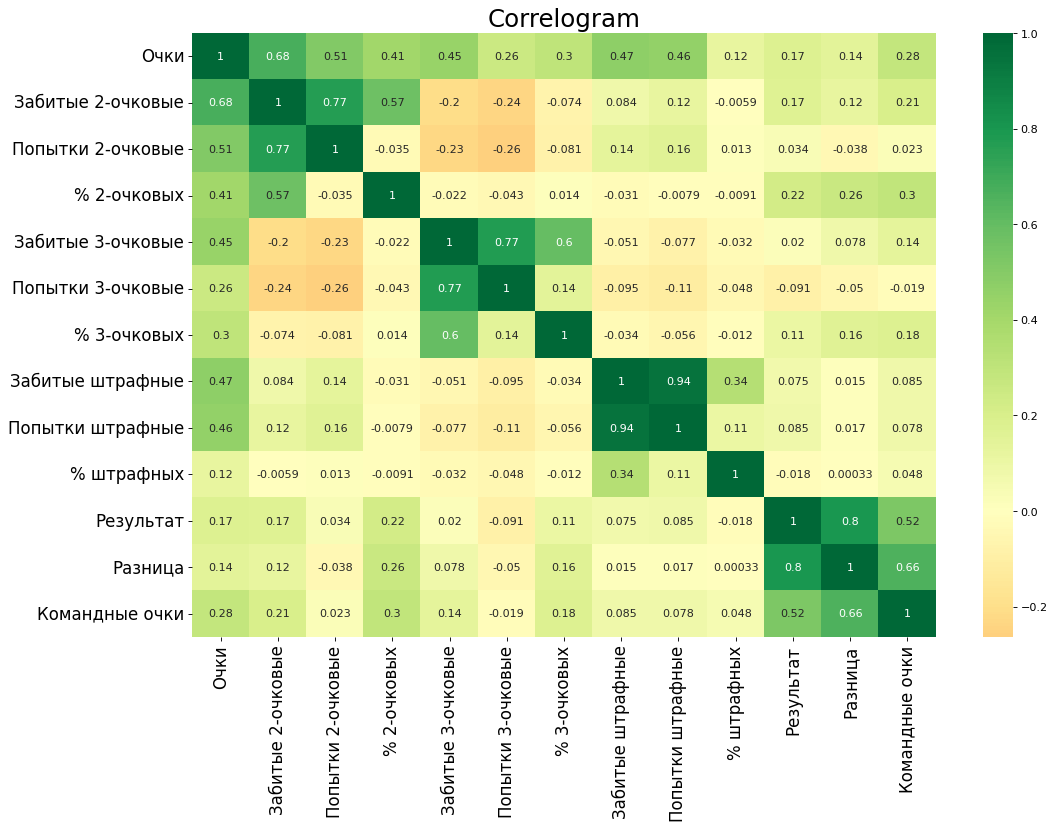

In [17]:
plt.figure(figsize=(15,10), dpi= 80)
statistic_attack = statistic[['Имя', 'Команда', 'Очки', 'Забитые 2-очковые', 'Попытки 2-очковые',
       '% 2-очковых', 'Забитые 3-очковые', 'Попытки 3-очковые', '% 3-очковых',
       'Забитые штрафные', 'Попытки штрафные', '% штрафных', 'Результат',
       'Разница', 'Командные очки']]
sns.heatmap(statistic_attack.corr(), xticklabels=statistic_attack.corr().columns, yticklabels=statistic_attack.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Видим, что наибольший вклад в очки игрока по прежнему вносят двухочковые, затем трехочковые и лишь затем забитые штрафные. Тогда как на результат команды ни один из атакующих факторов не оказывает подавляющее воздействие. Зато видно, что при увеличении попыток штрафных бросков значительно возратает количество попаданий, то есть штрафные броски являются самыми лёгкими.

<Figure size 720x576 with 0 Axes>

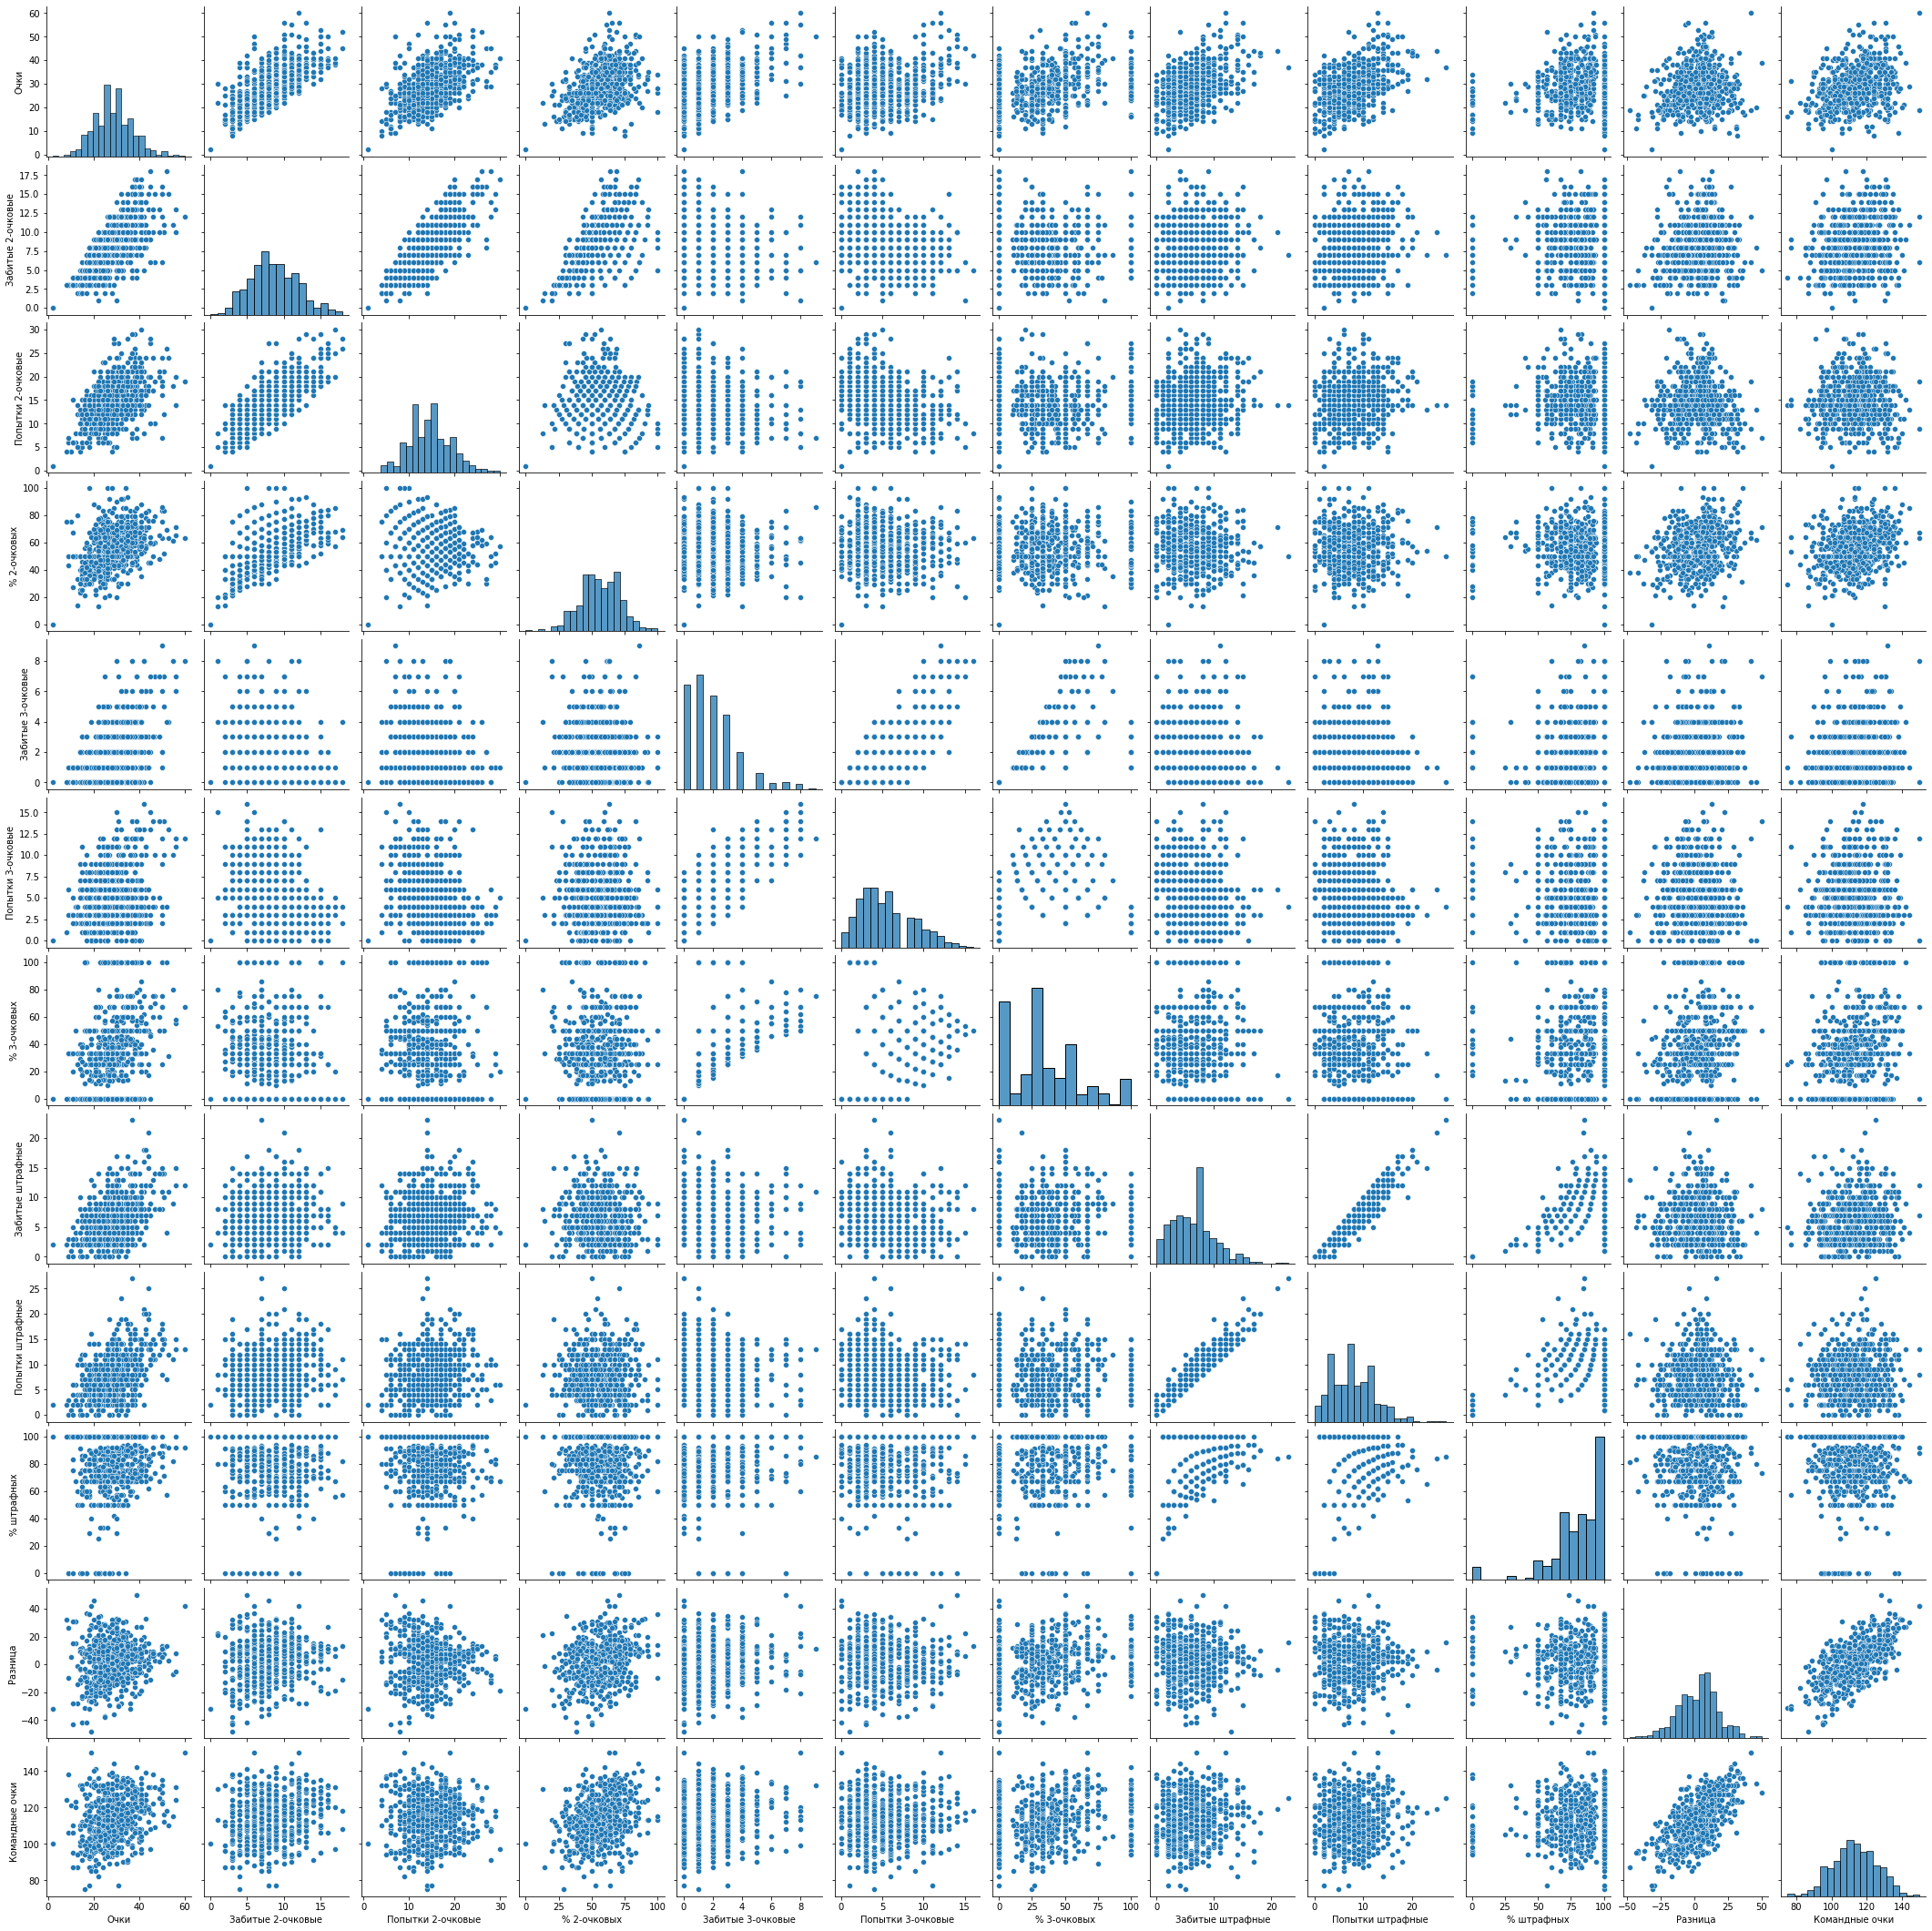

In [18]:
plt.figure(figsize=(10,8))
sns.pairplot(statistic_attack.reset_index(drop = True).drop(['Результат'], axis = 1), palette='bright')
plt.show()

In [20]:
statistic['Оппонент'].unique()

array(['Новый Орлеан', 'Бруклин', 'Оклахома-Сити', 'Нью-Йорк', 'Детройт',
       'Атланта', 'Чикаго', 'Миннесота', 'Орландо', 'Бостон', 'Шарлотт',
       'Юта', 'Голден Стэйт', 'Майами', 'Вашингтон', 'Торонто', 'Хьюстон',
       'Сан-Антонио', 'Клипперс', 'Лейкерс', 'Сакраменто', 'Даллас',
       'Финикс', 'Кливленд', 'Милуоки', 'Денвер', 'Индиана', 'Мемфис',
       'Портленд', 'Филадельфия'], dtype=object)

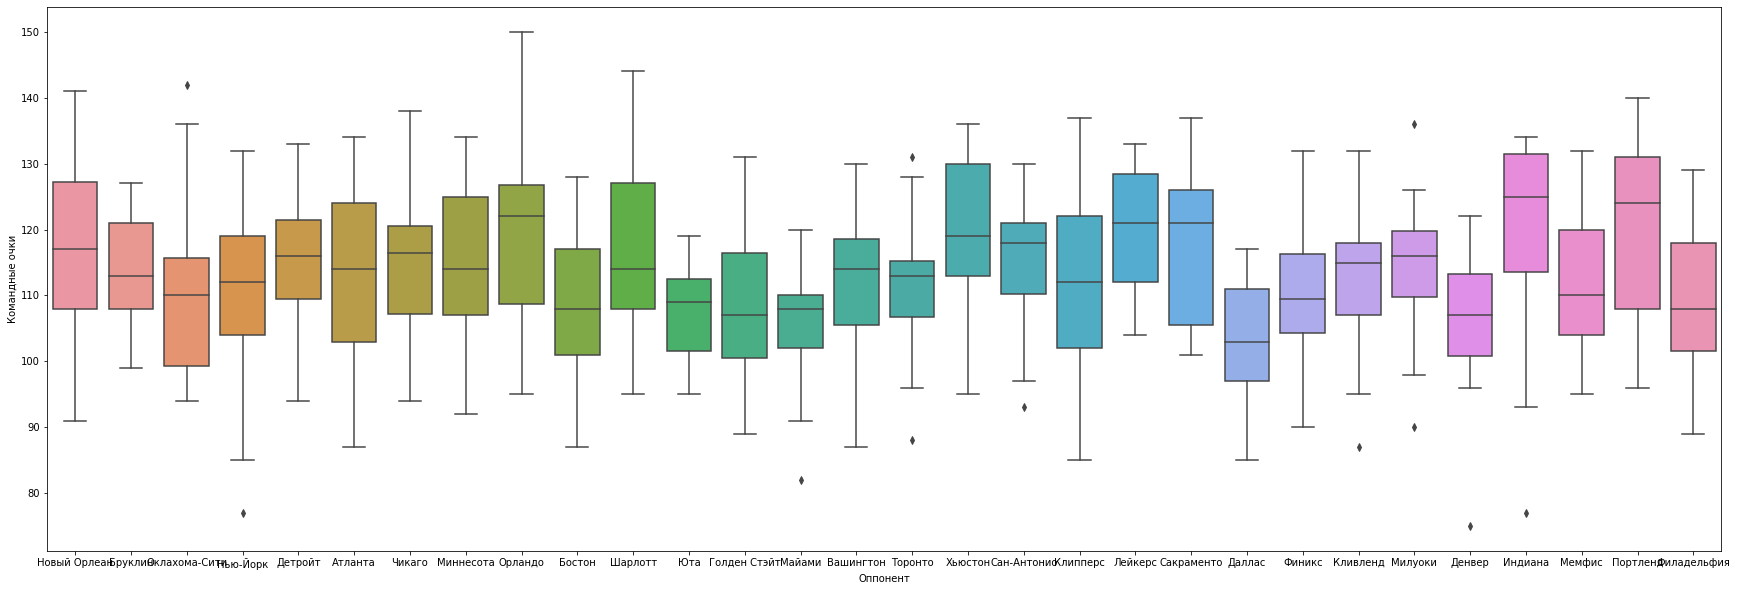

In [44]:
plt.figure(figsize=(30,10))
sns.boxplot(
    x='Оппонент', 
    y='Командные очки', 
    data=statistic)

plt.show()